Настраиваем импорт из Kaggle

In [ ]:
#KGAT_746a8c48819a19cbaf8ca0048244831b

In [ ]:
!pip install opendatasets
!pip install pandas


Библиотеки

In [ ]:
import opendatasets as od
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin

Для задачи классификации был взят датасет с данными сайта MyAnimeList. В нём содержится информация об аниме-тайтлах: название, жанры, студии, тип (TV/OVA/фильм и т.д.), сезон выхода, демографический таргет, количество эпизодов, число участников в списках (`Members`) и другие признаки.  
Практическая задача: предсказать, будет ли аниме успешным с точки зрения зрителей. Данная задача применима с практической точки зрения для многих компаний, решающих, в какой проект вложить деньги для последующей прибыли от популярности тайтла.

In [ ]:
od.download("https://www.kaggle.com/datasets/syahrulapriansyah2/myanimelist-2025")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: angrytea
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/syahrulapriansyah2/myanimelist-2025


100%|██████████| 9.57M/9.57M [00:00<00:00, 950MB/s]

Чтение датасета и просмотр столбцов

In [ ]:
pd.set_option("display.max_columns", None)
df = pd.read_csv("myanimelist-2025/mal_anime.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19931 entries, 0 to 19930
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   myanimelist_id   19931 non-null  int64  
 1   title            19931 non-null  object 
 2   description      19875 non-null  object 
 3   image            19544 non-null  object 
 4   Type             19534 non-null  object 
 5   Episodes         19549 non-null  object 
 6   Status           19549 non-null  object 
 7   Premiered        6343 non-null   object 
 8   Released_Season  6182 non-null   object 
 9   Released_Year    6182 non-null   float64
 10  Source           19166 non-null  object 
 11  Genres           18270 non-null  object 
 12  Themes           11217 non-null  object 
 13  Studios          19549 non-null  object 
 14  Producers        19549 non-null  object 
 15  Demographic      6522 non-null   object 
 16  Duration         19549 non-null  object 
 17  Rating      

Удаляем строки, не имеющие в Members значения

In [ ]:
df["Members"] = pd.to_numeric(df["Members"], errors="coerce")
df = df.dropna(subset=["Members"])

Задаем условие успешности: тайтл успешный, если у него 75% и больше зрителей:
1 - аниме успешное (собрало много просмотров)
0 - не успешное

In [ ]:
th = df["Members"].quantile(0.75)

df["hit"] = (df["Members"] >= th).astype(int)

/tmp/ipython-input-2710648394.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hit"] = (df["Members"] >= th).astype(int)


<class 'pandas.core.frame.DataFrame'>
Index: 6025 entries, 1496 to 19930
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   myanimelist_id   6025 non-null   int64  
 1   title            6025 non-null   object 
 2   description      6024 non-null   object 
 3   image            6020 non-null   object 
 4   Type             6019 non-null   object 
 5   Episodes         6025 non-null   object 
 6   Status           6025 non-null   object 
 7   Premiered        1286 non-null   object 
 8   Released_Season  1268 non-null   object 
 9   Released_Year    1268 non-null   float64
 10  Source           5748 non-null   object 
 11  Genres           5155 non-null   object 
 12  Themes           2627 non-null   object 
 13  Studios          6025 non-null   object 
 14  Producers        6025 non-null   object 
 15  Demographic      2523 non-null   object 
 16  Duration         6025 non-null   object 
 17  Rating         

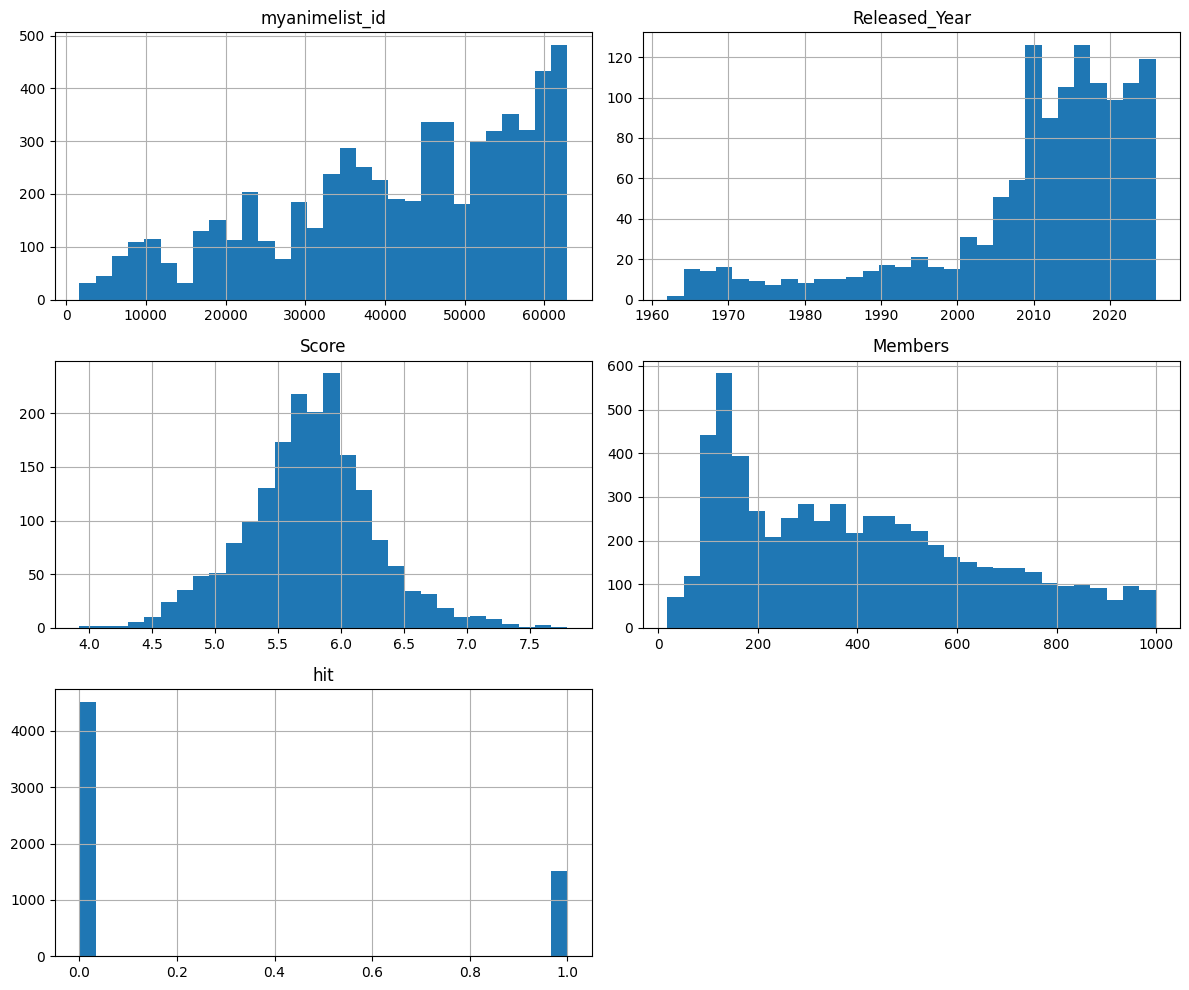


Распределение классов hit:
hit
0    0.749544
1    0.250456
Name: proportion, dtype: float64


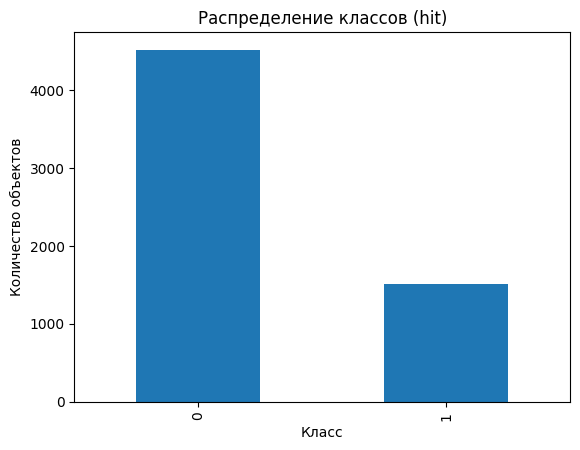

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df.info()

print("\nПропуски по столбцам:")
print(df.isna().sum().sort_values(ascending=False))

print("\nКоличество полностью дублирующихся строк:", df.duplicated().sum())

print("\nЧисловые признаки:")
print(df.describe())

print("\nКатегориальные признаки:")
print(df.describe(include="object"))

num_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
df[num_cols].hist(figsize=(12, 10), bins=30)
plt.tight_layout()
plt.show()

print("\nРаспределение классов hit:")
print(df["hit"].value_counts(normalize=True))

df["hit"].value_counts().plot(kind="bar")
plt.title("Распределение классов (hit)")
plt.xlabel("Класс")
plt.ylabel("Количество объектов")
plt.show()


Для признаков возьмем Source, Type, Released_Season, Episodes, Genres, Studios, Demographic

Пропуски по эпизодам заменяем медианой, по категориальным признакам на Unknown, жанрам и студиям поставим пустые строки

In [ ]:
df["Episodes"] = pd.to_numeric(df["Episodes"], errors="coerce")
m_episodes = df["Episodes"].median()
df["Episodes"] = df["Episodes"].fillna(m_episodes)

for col in ["Source", "Type", "Released_Season", "Demographic"]:
    df[col] = df[col].fillna("Unknown")

for col in ["Genres", "Studios"]: df[col] = df[col].fillna("")


Создаем список жанров

In [ ]:
df["Genres_l"] = df["Genres"].apply(lambda x: [i.strip() for i in str(x).split(",") if i.strip() != ""])

Ищем самые популярные жанры и делаем для них колонки

In [ ]:
genre_count = Counter()

for g in df["Genres_l"]:
    genre_count.update(g)

top_g = [i for i, _ in genre_count.most_common(10)]

for g in top_g:
    col_name = f"genre_{g}"
    df[col_name] = df["Genres_l"].apply(lambda lst: int(g in lst))

g_cols = [f"genre_{g}" for g in top_g]
df[g_cols].head()

,genre_Comedy,genre_Fantasy,genre_Adventure,genre_Action,genre_Slice of Life,genre_Sci-Fi,genre_Drama,genre_Supernatural,genre_Sports,genre_Avant Garde
1496,1,0,0,0,0,0,0,0,0,0
1570,0,0,0,0,0,0,0,0,0,0
1691,0,1,1,0,0,0,0,0,0,0
1831,1,0,0,0,0,0,0,0,0,0
1835,0,0,0,0,0,1,0,0,0,0


Список студий делаем

In [ ]:
df["Studios_l"] = df["Studios"].apply(lambda x: [i.strip() for i in str(x).split(",") if i.strip() != ""])

Ищем популярные студии

In [ ]:
studio_count = Counter()

for s in df["Studios_l"]: studio_count.update(s)

top_s = [i for i, _ in studio_count.most_common(10)]
top_s

['add some',
 'Toei Animation',
 'DLE',
 'TMS Entertainment',
 'Shin-Ei Animation',
 'Nippon Animation',
 'Kachidoki Studio',
 'Sunrise',
 'AQUA ARIS',
 'Fanworks']

Не учитываем 'add some'

In [ ]:
studio_count = Counter()
for s in df["Studios_l"]:
  for st in s:
    clean_s = st.strip()
    if "add some" in clean_s.lower(): continue
    studio_count[clean_s] += 1

top_s = [i for i, _ in studio_count.most_common(10)]
top_s

['Toei Animation',
 'DLE',
 'TMS Entertainment',
 'Shin-Ei Animation',
 'Nippon Animation',
 'Kachidoki Studio',
 'Sunrise',
 'AQUA ARIS',
 'Fanworks',
 'OLM']

Задаем колонки

In [ ]:
for s in top_s:
    col_name = f"studio_{s}"
    df[col_name] = df["Studios_l"].apply(lambda lst: int(s in lst))

studio_cols = [f"studio_{s}" for s in top_s]
df[studio_cols].head()

,studio_Toei Animation,studio_DLE,studio_TMS Entertainment,studio_Shin-Ei Animation,studio_Nippon Animation,studio_Kachidoki Studio,studio_Sunrise,studio_AQUA ARIS,studio_Fanworks,studio_OLM
1496,0,0,0,0,0,0,0,0,0,0
1570,0,0,0,0,0,0,0,0,0,0
1691,0,0,0,0,0,0,0,0,0,1
1831,0,0,0,0,0,0,0,0,0,0
1835,0,0,0,0,0,0,1,0,0,0


Собираем матрицу X из фич и назначаем целевую переменную успешности y

In [ ]:
num = ["Episodes"] + g_cols + studio_cols
categ = ["Source", "Type", "Released_Season", "Demographic"]
feature = num + categ

X = df[feature]
y = df["hit"]

Делим данные на train и test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)


Создание бейзлайна

Числовые и бинарные признаки будем масштабировать, а для категориальных используем one-hot encoding

In [ ]:
pred = ColumnTransformer(transformers=[
    ("num", StandardScaler(),num),
    ("categ", OneHotEncoder(handle_unknown="ignore"), categ)
])

Возьмем фиксированное KNN с 5 соседями

In [ ]:
knn_b = KNeighborsClassifier(n_neighbors=5, weights="uniform")
model_b = Pipeline(steps=[("pred", pred),("classifier", knn_b)])

model_b.fit(X_train, y_train)

Pipeline(steps=[('pred',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Episodes', 'genre_Comedy',
                                                   'genre_Fantasy',
                                                   'genre_Adventure',
                                                   'genre_Action',
                                                   'genre_Slice of Life',
                                                   'genre_Sci-Fi',
                                                   'genre_Drama',
                                                   'genre_Supernatural',
                                                   'genre_Sports',
                                                   'genre_Avant Garde',
                                                   'studio_Toei Animation',
                                                   'studio_DLE',
                                                   'studio_TMS Entertainment',
                                                   'studio_Shin-Ei Animation',
                                                   'studio_Nippon Animation',
                                                   'studio_Kachidoki Studio',
                                                   'studio_Sunrise',
                                                   'studio_AQUA ARIS',
                                                   'studio_Fanworks',
                                                   'studio_OLM']),
                                                 ('categ',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Source', 'Type',
                                                   'Released_Season',
                                                   'Demographic'])])),
                ('classifier', KNeighborsClassifier())])

В данных наблюдается заметный дисбаланс классов: доля неуспешных тайтлов составляет около 75%, а успешных — около 25%. В такой ситуации одной accuracy недостаточно: модель может давать высокую долю правильных ответов, практически всегда предсказывая класс 0, и при этом почти не находить хиты.  
Используем метрики такие как  
Accuracy - общая доля правильных ответов. Показывает, какой процент объектов модель классифицирует правильно в целом. Удобна как базовый ориентир, но чувствительна к дисбалансу классов.  
Recall - доля найденных моделью успешных тайтлов среди всех реально успешных.  
Precision - доля реально успешных тайтлов среди всех объектов, предсказанных как hit  
F1-score - среднее между precision и recall. Эта метрика хорошо подходит при дисбалансе классов и приоритетном интересе к одному из классов, так как учитывает баланс между тем, чтобы не пропускать хиты и не предсказывать слишком много ложных хитов.  
ROC-AUC - площадь под ROC-кривой. Показывает, насколько хорошо модель ранжирует объекты класса 1 выше, чем объекты класса 0, по своим вероятностям. Значение 0.5 соответствует случайным угадываниям, значения ближе к 1 означают хорошее разделение классов.  
Основной упор сделаем на метрику F1, так как нам надо качество обнаружения успешных тайтлов при дисбалансе классов. Остальных используем для общей картины.

Проводим оценку модели.
Доля класса 0 в данных 0.75, accuracy 0.74. Что означает, что модель будет стараться всегда предсказать 0. Для класса 0 метрики высокие: precision = 0.78, recall = 0.90. Это значит, что среди объектов, которые модель помечает как «0», большинство действительно неуспешные, и модель находит примерно 90% всех неуспешных тайтлов.   
Однако по классу 1 модель выдает precision 0.46, что означает, что примерно половину из необходимых она угадывает правильно. Recall 0.25, то есть находится лишь четверть всех реально успешных тайтлов. ROC_AUC 0.66 означает, что модель работает немного лучше просто угадывания. F1 всего 0.32  
Модель очень осторожно предсказывает класс 1 и пропускает большинство хитов.

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report

y_pred_base = model_b.predict(X_test)
y_proba_base = model_b.predict_proba(X_test)[:, 1]

acc_base = accuracy_score(y_test, y_pred_base)
f1_base = f1_score(y_test, y_pred_base)
roc_base = roc_auc_score(y_test, y_proba_base)

print("БЕЙЗЛАЙН (KNN, k=5)")
print("Accuracy:", acc_base)
print("F1-score", f1_base)
print("ROC-AUC:", roc_base)
print("\nОтчёт по классам:")
print(classification_report(y_test, y_pred_base))


БЕЙЗЛАЙН (KNN, k=5)
Accuracy: 0.7377593360995851
F1-score 0.3247863247863248
ROC-AUC: 0.6615439337601665

Отчёт по классам:
              precision    recall  f1-score   support

           0       0.78      0.90      0.84       903
           1       0.46      0.25      0.32       302

    accuracy                           0.74      1205
   macro avg       0.62      0.58      0.58      1205
weighted avg       0.70      0.74      0.71      1205



In [ ]:
y_test.value_counts(normalize=True)

,proportion
hit,
0,0.749378
1,0.250622


Улучшение бейзлайна

1.   Если подобрать число соседей и тип весов с помощью валидации, то улучшится качество по метрике ROC-AUC и F1 score
2.   Количество серий может сильно варьироваться и искажать расстрояние между признаками. Возможно, использование log(Episodes+1) поможет  
3. Надо увеличить топ жанров и студий, что даст модели больше информации о содержании





Начнем с первой гипотезы, задаем модель и параметры

In [ ]:
pred = ColumnTransformer(transformers=[
    ("num", StandardScaler(),num),
    ("categ", OneHotEncoder(handle_unknown="ignore"), categ)
])
knn = KNeighborsClassifier()
model_n = Pipeline(steps=[("pred", pred),("classifier", knn)])

param = {"classifier__n_neighbors": [3, 5, 7, 9, 11, 15], "classifier__weights": ["uniform", "distance"]}

кросс валидация с cv=3 с f1 как целевая метрика, так как он лучше отражает качество обнаружения успешных тайтлов при дисбалансе классов.

In [ ]:
grid_search = GridSearchCV(estimator=model_n, param_grid=param, scoring="f1", cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Лучшие параметры:", grid_search.best_params_)
print("Лучший F1 на кросс-валидации:", grid_search.best_score_)

Лучшие параметры: {'classifier__n_neighbors': 3, 'classifier__weights': 'distance'}
Лучший F1 на кросс-валидации: 0.3455959526576397


In [ ]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_proba)

print("Accuracy:", acc)
print("F1-score", f1)
print("ROC-AUC:", roc)
print("\nОтчёт по классам:")
print(classification_report(y_test, y_pred))

Accuracy: 0.7211618257261411
F1-score 0.35384615384615387
ROC-AUC: 0.6308313715136447

Отчёт по классам:
              precision    recall  f1-score   support

           0       0.79      0.86      0.82       903
           1       0.42      0.30      0.35       302

    accuracy                           0.72      1205
   macro avg       0.60      0.58      0.59      1205
weighted avg       0.70      0.72      0.70      1205



С помощью GridSearch выявилось, что лучше всего n_neighbors = 3, weights = "distance".  
По сравнению с исходным бейзлайном F1-score по классу hit вырос с ~0.32 до ~0.35, а recall хитов увеличился с 0.25 до 0.30. Это означает, что модель стала лучше находить успешные тайтлы и реже их пропускать.  
При этом precision по классу hit немного снизился (с 0.46 до 0.42), а accuracy и ROC-AUC уменьшились (accuracy с ~0.74 до ~0.72, ROC-AUC с ~0.66 до ~0.63). То есть модель стала чаще предсказывать класс 1, за счёт чего находит больше хитов, но и чаще ошибается на объектах класса 0.  
Модель стала немного полезнее, не смотря на небольшое увеличение ошибок не хитов.

2 гипотеза

In [ ]:
df["Episodes_log"] = np.log1p(df["Episodes"])

Собираем новые признаки и обучаем

In [ ]:
num_log = ["Episodes_log"] + g_cols + studio_cols

feature_log = num_log + categ

X_log = df[feature_log]
y = df["hit"]

X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_log, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

pred_log = ColumnTransformer(transformers=[
    ("num", StandardScaler(), num_log),
    ("categ", OneHotEncoder(handle_unknown="ignore"), categ),
])

knn = KNeighborsClassifier()

model_log = Pipeline(steps=[
    ("preprocess", pred_log),
    ("classifier", knn),
])

param = {
    "classifier__n_neighbors": [3, 5, 7, 9, 11, 15],
    "classifier__weights": ["uniform", "distance"],
}

grid_search_log = GridSearchCV(
    estimator=model_log,
    param_grid=param,
    scoring="f1",
    cv=3,
    n_jobs=-1
)

grid_search_log.fit(X_train_log, y_train_log)

print("Лучшие параметры (log Episodes):", grid_search_log.best_params_)
print("Лучший F1 на кросс-валидации (log Episodes):", grid_search_log.best_score_)
best_model_log = grid_search_log.best_estimator_

y_pred_log = best_model_log.predict(X_test_log)
y_proba_log = best_model_log.predict_proba(X_test_log)[:, 1]

acc_log = accuracy_score(y_test_log, y_pred_log)
f1_log = f1_score(y_test_log, y_pred_log)
roc_log = roc_auc_score(y_test_log, y_proba_log)

Лучшие параметры (log Episodes): {'classifier__n_neighbors': 3, 'classifier__weights': 'distance'}
Лучший F1 на кросс-валидации (log Episodes): 0.34623156613133393


Метрики

In [ ]:
print("УЛУЧШЕННЫЙ KNN + log(Episodes)")
print("Accuracy:", acc_log)
print("F1-score:", f1_log)
print("ROC-AUC:", roc_log)
print("\nОтчёт по классам:")
print(classification_report(y_test_log, y_pred_log))

УЛУЧШЕННЫЙ KNN + log(Episodes)
Accuracy: 0.7203319502074689
F1-score: 0.3481624758220503
ROC-AUC: 0.6391443532595542

Отчёт по классам:
              precision    recall  f1-score   support

           0       0.79      0.86      0.82       903
           1       0.42      0.30      0.35       302

    accuracy                           0.72      1205
   macro avg       0.60      0.58      0.59      1205
weighted avg       0.69      0.72      0.70      1205



Модель с логарифмированным признаком показала метрики, очень близкие к варианту без логарифма: accuracy ≈ 0.72, F1 по классу hit ≈ 0.35, ROC-AUC ≈ 0.64. Наблюдаемые отличия не носят существенного характера и не дают однозначного изменения качества

3 гипотеза

Студии и жанры были до этого подчищены и посчитаны, используем заново

In [ ]:
top_s1 = [i for i, _ in studio_count.most_common(20)]
for s in top_s1:
    col_name = f"studio_{s}"
    df[col_name] = df["Studios_l"].apply(lambda lst: int(s in lst))

studio_cols1 = [f"studio_{s}" for s in top_s1]

top_g1 = [i for i, _ in genre_count.most_common(20)]

for g in top_g1:
    col_name = f"genre_{g}"
    df[col_name] = df["Genres_l"].apply(lambda lst: int(g in lst))

g_cols1 = [f"genre_{g}" for g in top_g1]

Обучаем с кросс валидацией

In [ ]:
num = ["Episodes"] + g_cols1 + studio_cols1
categ = ["Source", "Type", "Released_Season", "Demographic"]
feature = num + categ

X = df[feature]
y = df["hit"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

pred = ColumnTransformer(transformers=[
    ("num", StandardScaler(), num),
    ("categ", OneHotEncoder(handle_unknown="ignore"), categ),
])

knn = KNeighborsClassifier()

model_n = Pipeline(steps=[
    ("pred", pred),
    ("classifier", knn),
])

param = {
    "classifier__n_neighbors": [3, 5, 7, 9, 11, 15],
    "classifier__weights": ["uniform", "distance"],
}

grid_search = GridSearchCV(
    estimator=model_n,
    param_grid=param,
    scoring="f1",
    cv=3,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Лучшие параметры:", grid_search.best_params_)
print("Лучший F1 на кросс-валидации:", grid_search.best_score_)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_proba)

print("KNN с top-20 жанров/студий")
print("Accuracy:", acc)
print("F1-score:", f1)
print("ROC-AUC:", roc)
print("\nОтчёт по классам:")
print(classification_report(y_test, y_pred))

Лучшие параметры: {'classifier__n_neighbors': 3, 'classifier__weights': 'distance'}
Лучший F1 на кросс-валидации: 0.3623397700179236
KNN с top-20 жанров/студий
Accuracy: 0.7203319502074689
F1-score: 0.37243947858473
ROC-AUC: 0.6470026328720306

Отчёт по классам:
              precision    recall  f1-score   support

           0       0.79      0.85      0.82       903
           1       0.43      0.33      0.37       302

    accuracy                           0.72      1205
   macro avg       0.61      0.59      0.60      1205
weighted avg       0.70      0.72      0.71      1205



Результаты показывают небольшое, но стабильное улучшение качества по целевой метрике: F1-score для класса hit вырос примерно с 0.35 до 0.37, а recall увеличился с 0.30 до 0.33 при сопоставимом уровне precision 0.43. Accuracy осталась на прежнем уровне 0.72, а ROC-AUC 0.65, что чуть ниже, чем у самого первого бейзлайна, но сопоставимо с предыдущими улучшенными моделями. Это означает, что более подробные признаки по жанрам и студиям действительно дают модели немного больше информации: она стала чуть лучше находить успешные тайтлы, не ухудшая общую точность.

Создание своего KNN-классификатора

Строим класс с гиперпараметрами, задаем обучение в виде запоминания данных, расчет дистанций соседей с помощью евклидова расстояния

Расстояния мы будем смотреть от тестового объекта до обучающего. Для этого необходимо создать матрицу расстояний. Квадрат в евклидовом расстоянии можно взять с вида x^2+z^2-2xz  
cross - матрица скалярных произведений

Считаем вероятности  
Если weight = uniform, то берем k соседей, считаем для каждого считаем долю классов соседей  
Если distance, то соседям даем веса, обратные расстоянию. Выбираем соседей, совпадающих по классу. Далее суммируем их веса и делим на сумму весов всех соседей.  

В predict выбираем классы по индексам максимальной вероятности.

In [ ]:
class MyKNN(BaseEstimator, ClassifierMixin):
  def __init__(self, neighbors=5, weights="uniform"):
    self.neighbors = neighbors
    self.weights = weights

  def fit(self, X, y):
    X = np.asarray(X)
    y = np.asarray(y)
    self.X_train = X
    self.y_train = y
    self.classes = np.unique(y)
    return self

  def distance(self,X):
    X = np.asarray(X)
    sq_X = np.sum(X**2,axis=1)[:, np.newaxis]
    sq_X_train = np.sum(self.X_train**2, axis=1)[np.newaxis, :]
    cross = X @ self.X_train.T
    dists = np.sqrt(np.maximum(sq_X + sq_X_train - 2*cross, 0.0))
    return dists

  def predict_proba(self, X):
    X = np.asarray(X)
    dist = self.distance(X)
    test = X.shape[0]
    train = self.X_train.shape[0]
    k = min(self.neighbors, train)

    neib_idx = np.argpartition(dist, k-1, axis=1)[:, :k]
    neib_dist = np.take_along_axis(dist, neib_idx, axis=1)
    neib_label = self.y_train[neib_idx]

    probab = np.zeros((test, len(self.classes)), dtype=float)
    for i in range(test):
      label_i = neib_label[i]
      dist_i = neib_dist[i]

      if self.weights == "uniform":
        for c_idx, c in enumerate(self.classes):
          probab[i, c_idx] = np.mean(label_i == c)
      elif self.weights == "distance":
        eps = 1e-8
        w = 1.0 / (dist_i + eps)
        for c_idx, c in enumerate(self.classes):
          mask = (label_i == c)
          if np.any(mask):
              probab[i, c_idx] = np.sum(w[mask]) / np.sum(w)
          else:
              probab[i, c_idx] = 0.0
      else:
          raise ValueError("must be 'uniform' or 'distance'")

    probab_sum = probab.sum(axis=1, keepdims=True)
    probab_sum[probab_sum == 0] = 1.0
    probab /= probab_sum
    return probab

  def predict(self, X):
    probab = self.predict_proba(X)
    indices = np.argmax(probab, axis=1)
    return self.classes[indices]


А теперь обучим получившуюся модель

In [ ]:
num = ["Episodes"] + g_cols + studio_cols
categ = ["Source", "Type", "Released_Season", "Demographic"]
feature = num + categ

X = df[feature]
y = df["hit"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

pred = ColumnTransformer(transformers=[
    ("num", StandardScaler(), num),
    ("categ", OneHotEncoder(handle_unknown="ignore"), categ),
])

my_base = Pipeline(steps=[("pred", pred), ("classifier", MyKNN(neighbors=5, weights="uniform"))])
my_base.fit(X_train, y_train)

y_pred_mbase = my_base.predict(X_test)
y_probab_mbase = my_base.predict_proba(X_test)[:,1]

print("=== MyKNN baseline ===")
print("Accuracy:", accuracy_score(y_test, y_pred_mbase))
print("F1-score:", f1_score(y_test, y_pred_mbase))
print("ROC-AUC:", roc_auc_score(y_test, y_probab_mbase))
print()
print(classification_report(y_test, y_pred_mbase))

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


=== MyKNN baseline ===
Accuracy: 0.7410788381742739
F1-score: 0.30666666666666664
ROC-AUC: 0.6739033977983616

              precision    recall  f1-score   support

           0       0.78      0.91      0.84       903
           1       0.47      0.23      0.31       302

    accuracy                           0.74      1205
   macro avg       0.62      0.57      0.57      1205
weighted avg       0.70      0.74      0.71      1205



Сравним бейзлайн с собственной реализацией на одних и тех же параметрах. На метриках небольшие различия в точности до сотых, но модели ведут себя одиноково. Предсказывают не хиты и боятся предсказывать хиты.

Теперь пройдемся по гипотезам с созданной моделью.

1 гипотеза:

In [ ]:
pred = ColumnTransformer(transformers=[
    ("num", StandardScaler(), num),
    ("categ", OneHotEncoder(handle_unknown="ignore"), categ),
])

my_knn1 = Pipeline(steps=[("pred", pred), ("classifier", MyKNN())])

param = {"classifier__neighbors": [3, 5, 7, 9, 11, 15], "classifier__weights": ["uniform", "distance"]}

grid_search = GridSearchCV(estimator=my_knn1, param_grid=param, scoring="f1", cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Лучшие параметры:", grid_search.best_params_)
print("Лучший F1 на кросс-валидации:", grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_proba)

print("Accuracy:", acc)
print("F1-score", f1)
print("ROC-AUC:", roc)
print("\nОтчёт по классам:")
print(classification_report(y_test, y_pred))

Лучшие параметры: {'classifier__neighbors': 3, 'classifier__weights': 'distance'}
Лучший F1 на кросс-валидации: 0.33764096642934094


/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Accuracy: 0.725311203319502
F1-score 0.35477582846003897
ROC-AUC: 0.6528642567453595

Отчёт по классам:
              precision    recall  f1-score   support

           0       0.79      0.87      0.83       903
           1       0.43      0.30      0.35       302

    accuracy                           0.73      1205
   macro avg       0.61      0.58      0.59      1205
weighted avg       0.70      0.73      0.71      1205



/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


При подборе гиперпараметров выявилось, что точно также лучшие параметры - 3 и distance.  
Две версии модели на первой гипотезе ведут себя похоже, имея приблизительно равные метрики. Что означает, что модель создана похожей на модель из библиотеки  
Если сравнивать с бейзлайн моделью моего KNN, то f1 вырос с 0.31 до 0.35, а recall с 0.23 до 0.30. Модель стала лучше находить успешные тайтлы и реже их пропускать. Accuracy и ROC-AUC немного снизились, что логично, так как ошибок на классе 0 становится больше из-за более частых предсказаний 1.  


2 гипотеза

In [ ]:
feature_log = num_log + categ

X_log = df[feature_log]
y = df["hit"]

X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_log, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


pred_log = ColumnTransformer(transformers=[
    ("num", StandardScaler(), num_log),
    ("categ", OneHotEncoder(handle_unknown="ignore"), categ),
])

model_log = Pipeline(steps=[
    ("preprocess", pred_log),
    ("classifier", MyKNN()),
])

param = {
    "classifier__neighbors": [3, 5, 7, 9, 11, 15],
    "classifier__weights": ["uniform", "distance"],
}

grid_search_log = GridSearchCV(
    estimator=model_log,
    param_grid=param,
    scoring="f1",
    cv=3,
    n_jobs=-1
)

grid_search_log.fit(X_train_log, y_train_log)

print("Лучшие параметры (log Episodes):", grid_search_log.best_params_)
print("Лучший F1 на кросс-валидации (log Episodes):", grid_search_log.best_score_)
best_model_log = grid_search_log.best_estimator_

y_pred_log = best_model_log.predict(X_test_log)
y_proba_log = best_model_log.predict_proba(X_test_log)[:, 1]

acc_log = accuracy_score(y_test_log, y_pred_log)
f1_log = f1_score(y_test_log, y_pred_log)
roc_log = roc_auc_score(y_test_log, y_proba_log)

print("УЛУЧШЕННЫЙ KNN + log(Episodes)")
print("Accuracy:", acc_log)
print("F1-score:", f1_log)
print("ROC-AUC:", roc_log)
print("\nОтчёт по классам:")
print(classification_report(y_test_log, y_pred_log))

Лучшие параметры (log Episodes): {'classifier__neighbors': 3, 'classifier__weights': 'distance'}
Лучший F1 на кросс-валидации (log Episodes): 0.3500220945276465


/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


УЛУЧШЕННЫЙ KNN + log(Episodes)
Accuracy: 0.7286307053941908
F1-score: 0.36007827788649704
ROC-AUC: 0.6640521293994265

Отчёт по классам:
              precision    recall  f1-score   support

           0       0.79      0.87      0.83       903
           1       0.44      0.30      0.36       302

    accuracy                           0.73      1205
   macro avg       0.61      0.59      0.59      1205
weighted avg       0.70      0.73      0.71      1205



/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


При сравнении собственной реализации модели и существующей на 2 гипотезе практически идентичное качество. Гиперапараметры подбирются те же самые.  
Если рассматривать изменения между 1 и 2 гипотезой в пределах собственной реализации KNN, то заметен небольшой прирост, что говорит, что не эффективно, но логарифмирование немного добавляет качества.

3 гипотеза

In [ ]:
top_s1 = [i for i, _ in studio_count.most_common(20)]
for s in top_s1:
    col_name = f"studio_{s}"
    df[col_name] = df["Studios_l"].apply(lambda lst: int(s in lst))

studio_cols1 = [f"studio_{s}" for s in top_s1]

top_g1 = [i for i, _ in genre_count.most_common(20)]

for g in top_g1:
    col_name = f"genre_{g}"
    df[col_name] = df["Genres_l"].apply(lambda lst: int(g in lst))

g_cols1 = [f"genre_{g}" for g in top_g1]

num = ["Episodes"] + g_cols1 + studio_cols1
categ = ["Source", "Type", "Released_Season", "Demographic"]
feature = num + categ

X = df[feature]
y = df["hit"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

pred = ColumnTransformer(transformers=[
    ("num", StandardScaler(), num),
    ("categ", OneHotEncoder(handle_unknown="ignore"), categ),
])

model_n = Pipeline(steps=[
    ("pred", pred),
    ("classifier", MyKNN()),
])

param = {
    "classifier__neighbors": [3, 5, 7, 9, 11, 15],
    "classifier__weights": ["uniform", "distance"],
}

grid_search = GridSearchCV(
    estimator=model_n,
    param_grid=param,
    scoring="f1",
    cv=3,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Лучшие параметры:", grid_search.best_params_)
print("Лучший F1 на кросс-валидации:", grid_search.best_score_)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_proba)

print("KNN с top-20 жанров/студий")
print("Accuracy:", acc)
print("F1-score:", f1)
print("ROC-AUC:", roc)
print("\nОтчёт по классам:")
print(classification_report(y_test, y_pred))

Лучшие параметры: {'classifier__neighbors': 3, 'classifier__weights': 'distance'}
Лучший F1 на кросс-валидации: 0.3594942416079509


/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


KNN с top-20 жанров/студий
Accuracy: 0.7385892116182573
F1-score: 0.390715667311412
ROC-AUC: 0.660159659120078

Отчёт по классам:
              precision    recall  f1-score   support

           0       0.80      0.87      0.83       903
           1       0.47      0.33      0.39       302

    accuracy                           0.74      1205
   macro avg       0.63      0.60      0.61      1205
weighted avg       0.71      0.74      0.72      1205



/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Видно заметное улучшение f1, recall, precision, accuracy. Модель стала чаще находить хиты, а среди них увеличилось число успешно найденных. От чего ROC-AUC немного упал, но в целом остался на том же уровне.  
Если рассматривать относительно 3 гипотезы для модели из библиотеки, то можно увидеть, что они похожи, но собственная реализация дает немного более высокое значение метрик

**Итоговый вывод**  
В итоге для задачи классификации KNN показал, что при разумном подборе гиперпараметров и признаков (логарифм эпизодов, расширение жанров/студий, k=3, weights="distance") можно чуть поднять F1 и лучше находить успешные тайтлы, но чудесного роста качества добиться не получилось. Моя собственная реализация KNN даёт практически те же результаты, что и библиотечный KNeighborsClassifier, так что её можно считать корректной. А главный вклад в качество здесь дают не столько собственные реализации в коде, сколько аккуратный препроцессинг и настройки модели.